In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.gridspec as gridspec

In [3]:
sns.set(style='whitegrid')
sns.set_palette("pastel")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [4]:
# 1. Ekman 감정군 정의 (코드 재사용)
emotion_groups_ekman = {
    'happiness': ['joy', 'amusement', 'excitement', 'pride', 'gratitude', 'relief', 'love', 'caring'],
    'sadness': ['sadness', 'disappointment', 'remorse', 'grief'],
    'anger': ['anger', 'annoyance', 'disapproval'],
    'fear': ['fear', 'nervousness'],
    'disgust': ['disgust', 'embarrassment'],
    'surprise': ['surprise', 'realization', 'confusion'],
    'neutral': ['neutral'] # Ekman 기본 6종 외 neutral은 일단 제외 (필요시 추가)
}

In [5]:
# 2. 감정군 집계 함수 (코드 재사용)
def process_platform_emotions(df, date_col):
    """
    주어진 DataFrame에서 날짜 컬럼을 기준으로 주 단위 Ekman 감정 평균을 계산합니다.

    Args:
        df (pd.DataFrame): 원본 데이터프레임. GoEmotions 28개 감정 점수 컬럼 포함.
        date_col (str): 날짜 정보를 담고 있는 컬럼 이름.

    Returns:
        pd.DataFrame: 주(week)별 6가지 Ekman 감정 평균 점수를 포함하는 데이터프레임.
                      'week' 컬럼과 Ekman 감정 컬럼들을 포함.
                      오류 발생 시 빈 DataFrame 반환.
    """        
    # 원본 데이터프레임 복사하여 작업
    df_processed = df.copy()

    # 날짜 변환 및 주 단위 추출
    df_processed[date_col] = pd.to_datetime(df_processed[date_col], errors='coerce').dt.tz_localize(None)
    df_processed = df_processed.dropna(subset=[date_col])
    df_processed['week'] = df_processed[date_col].dt.to_period('W').apply(lambda r: r.start_time)

    # Ekman 감정군 계산
    missing_emotions = []
    for group, emotions in emotion_groups_ekman.items():
        # 원본 데이터에 있는 감정 컬럼만 필터링
        valid_emotions = [e for e in emotions if e in df_processed.columns]
        if not valid_emotions:
            missing_emotions.append(group)
            df_processed[group] = np.nan # 해당하는 세부 감정이 하나도 없으면 NaN 처리
            continue
            
        # 존재하는 감정 컬럼들의 평균 계산
        df_processed[group] = df_processed[valid_emotions].mean(axis=1)

    if missing_emotions:
        print(f"경고: 다음 Ekman 그룹에 해당하는 세부 감정 컬럼이 원본 데이터에 없어 NaN으로 처리됩니다: {missing_emotions}")

    # 주 단위 감정군 평균 집계
    ekman_cols = list(emotion_groups_ekman.keys())
    weekly_df = df_processed.groupby('week')[ekman_cols].mean().reset_index()
    
    return weekly_df

In [6]:
public_df = pd.read_csv('./ready/public_media_vaccine.csv', encoding='utf-8-sig')
civil_df = pd.read_csv('./ready/civil_platform_vaccine.csv', encoding='utf-8-sig')

# 주 단위 Ekman 감정 집계
weekly_public = process_platform_emotions(public_df, 'pub_date')
weekly_civil = process_platform_emotions(civil_df, 'pub_date')

# --- 기술 통계량 계산 ---
if not weekly_public.empty and not weekly_civil.empty:
    stats_public = weekly_public[list(emotion_groups_ekman.keys())].describe()
    stats_civil = weekly_civil[list(emotion_groups_ekman.keys())].describe()

    # 두 플랫폼 통계량 합치기 (보기 좋은 테이블 형태 구성)
    # 컬럼을 MultiIndex로 구성: (Platform, Statistic)
    stats_combined = pd.concat(
        [stats_public, stats_civil],
        axis=1,  # 컬럼 방향으로 합치기
        keys=['Public Media', 'Civil Platform']  # 최상위 컬럼 레벨 이름 지정
    ).swaplevel(0, 1, axis=1).sort_index(axis=1)  # 플랫폼별로 통계량 묶이도록 컬럼 레벨 변경 및 정렬

    # 감정을 인덱스로 변경 (더 보기 좋게)
    stats_final = stats_combined.T  # Transpose: 감정이 인덱스로, 통계량이 컬럼으로

    print("--- 주 단위 Ekman 감성 점수 기술 통계량 ---")
    display(stats_final.style.format("{:.4f}"))  # 소수점 4자리까지 표시하도록 스타일 적용 (표시용)

else:
    print("오류")

--- 주 단위 Ekman 감성 점수 기술 통계량 ---


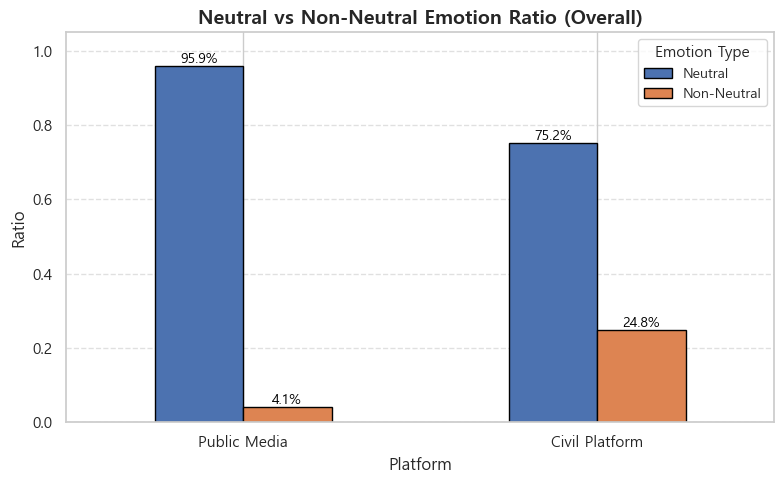

In [7]:
# --- 그래프 스타일 개선용 함수 ---
def plot_neutral_comparison(df):
    fig, ax = plt.subplots(figsize=(8, 5))

    colors = ['#4C72B0', '#DD8452']  # Neutral / Non-Neutral 컬러
    bars = df.plot(kind='bar', ax=ax, color=colors, edgecolor='black')

    # 막대 위에 비율(%) 표시
    for p in ax.patches:
        value = p.get_height()
        ax.annotate(f'{value:.1%}',  # 백분율 표시
                    (p.get_x() + p.get_width() / 2, value),
                    ha='center', va='bottom', fontsize=10, color='black')

    # 스타일 설정
    ax.set_title('Neutral vs Non-Neutral Emotion Ratio (Overall)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Ratio', fontsize=12)
    ax.set_xlabel('Platform', fontsize=12)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='both', labelsize=11)
    ax.legend(title='Emotion Type', fontsize=10, title_fontsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_axisbelow(True)

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# --- 데이터 준비 (기존 코드 활용) ---
total_public = weekly_public[emotion_groups_ekman.keys()].sum()
total_civil = weekly_civil[emotion_groups_ekman.keys()].sum()

def get_neutral_nonneutral_ratio(series):
    neutral = series['neutral']
    non_neutral = series.drop('neutral').sum()
    total = neutral + non_neutral
    return {
        'Neutral': neutral / total,
        'Non-Neutral': non_neutral / total
    }

ratio_public = get_neutral_nonneutral_ratio(total_public)
ratio_civil = get_neutral_nonneutral_ratio(total_civil)

ratios_df = pd.DataFrame({
    'Public Media': ratio_public,
    'Civil Platform': ratio_civil
}).T

# --- 그래프 출력 ---
plot_neutral_comparison(ratios_df)

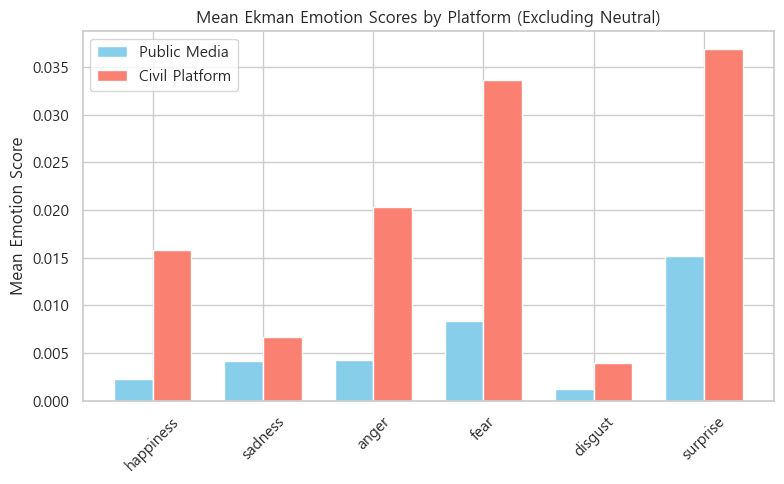

In [8]:
# 'neutral' 감정 제거
emotions_no_neutral = [e for e in emotion_groups_ekman.keys() if e.lower() != 'neutral']

# 평균 점수 추출
avg_public = stats_public.loc['mean', emotions_no_neutral]
avg_civil = stats_civil.loc['mean', emotions_no_neutral]

# x 위치 설정
x = np.arange(len(emotions_no_neutral))
bar_width = 0.35

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, avg_public, width=bar_width, label='Public Media', color='skyblue')
plt.bar(x + bar_width/2, avg_civil, width=bar_width, label='Civil Platform', color='salmon')

# 눈금 및 라벨 설정
plt.xticks(x, emotions_no_neutral, rotation=45)
plt.ylabel("Mean Emotion Score")
plt.title("Mean Ekman Emotion Scores by Platform (Excluding Neutral)")
plt.legend()
plt.tight_layout()
plt.show()

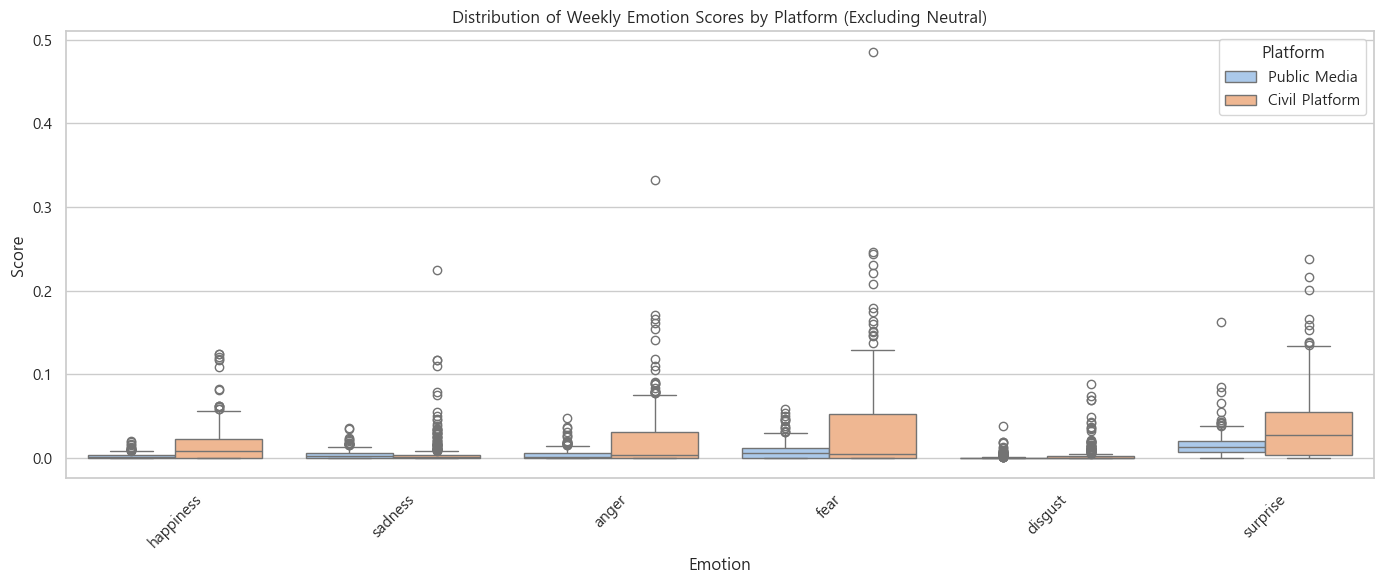

In [9]:
emotions_no_neutral = [e for e in emotion_groups_ekman.keys() if e.lower() != 'neutral']

# 플랫폼 라벨 추가 및 병합
weekly_public['Platform'] = 'Public Media'
weekly_civil['Platform'] = 'Civil Platform'
weekly_all = pd.concat([weekly_public, weekly_civil])

# long-format으로 변환
melted = weekly_all.melt(
    id_vars='Platform',
    value_vars=emotions_no_neutral,
    var_name='Emotion',
    value_name='Score'
)

# Boxplot 시각화
plt.figure(figsize=(14, 6))
sns.boxplot(data=melted, x='Emotion', y='Score', hue='Platform')
plt.title("Distribution of Weekly Emotion Scores by Platform (Excluding Neutral)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

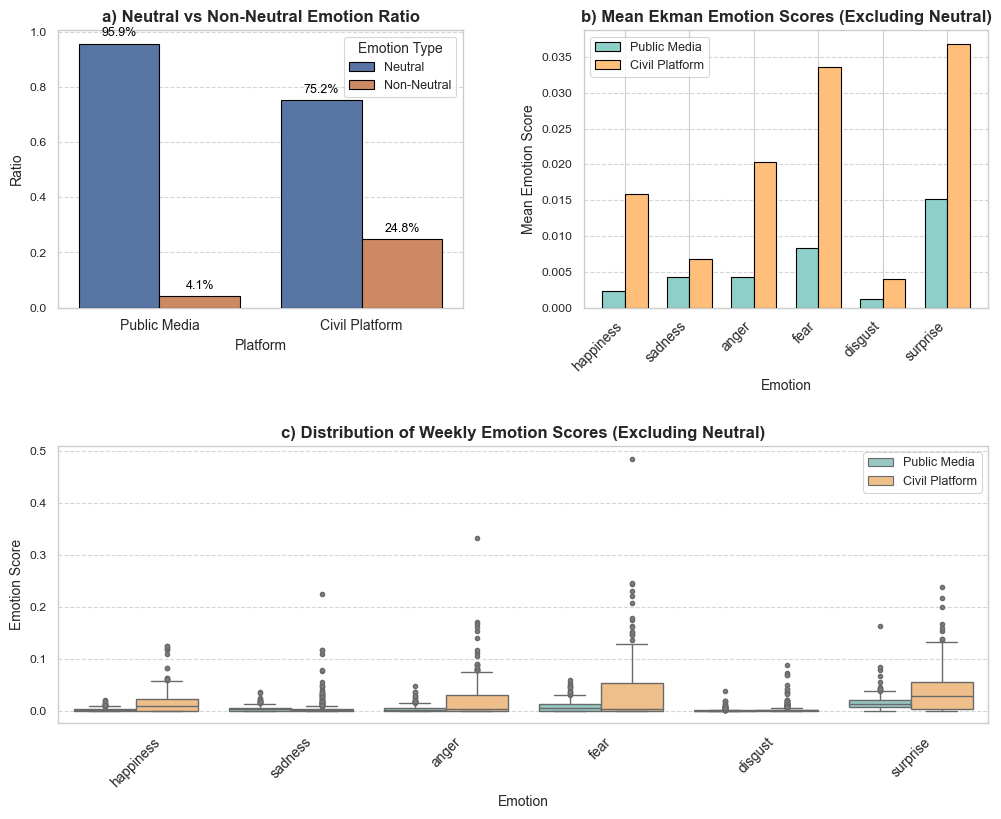

In [10]:
# --- 시각화 전용 변수 정의 ---
# 그래프에서 사용할 'neutral'을 제외한 감정 리스트
emotions_no_neutral = [emo for emo in emotion_groups_ekman.keys() if emo != 'neutral']

# --- 1. 사전 설정: 테마, 팔레트, 폰트 ---
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams['font.family'] = 'sans-serif'
platform_palette = {'Public Media': '#8ECFC9', 'Civil Platform': '#FFBE7A'}
# 그래프 (a)에서 사용할 새로운 팔레트
emotion_type_palette = {'Neutral': '#4C72B0', 'Non-Neutral': '#DD8452'}


# --- 2. Figure 및 GridSpec 레이아웃 설정 ---
fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.5, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# --- 3. 각 Subplot에 그래프 그리기 ---

# ======== 그래프 (a): Neutral vs Non-Neutral 비율 (그룹 막대그래프) ========
# 주 단위 점수들의 총합을 기준으로 Neutral/Non-Neutral 비율 계산
total_public_sum = weekly_public[list(emotion_groups_ekman.keys())].sum()
total_civil_sum = weekly_civil[list(emotion_groups_ekman.keys())].sum()

def get_neutral_nonneutral_ratio(series):
    neutral = series.get('neutral', 0)
    non_neutral = series.drop('neutral', errors='ignore').sum()
    total = neutral + non_neutral
    if total == 0:
        return {'Neutral': 0, 'Non-Neutral': 0}
    return {'Neutral': neutral / total, 'Non-Neutral': non_neutral / total}

ratios_df = pd.DataFrame({
    'Public Media': get_neutral_nonneutral_ratio(total_public_sum),
    'Civil Platform': get_neutral_nonneutral_ratio(total_civil_sum)
}).T

# 데이터를 seaborn에 적합한 'long-form' 형태로 변환
ratios_for_plot = ratios_df.reset_index().rename(columns={'index': 'Platform'})
melted_ratios = ratios_for_plot.melt(
    id_vars='Platform',
    var_name='Emotion Type',
    value_name='Ratio'
)

# x축과 hue를 바꿔서 그룹 막대그래프 생성
sns.barplot(data=melted_ratios, x='Platform', y='Ratio', hue='Emotion Type',
            palette=emotion_type_palette, ax=ax1, edgecolor='black', zorder=3)

# 퍼센트 레이블 추가
for p in ax1.patches:
    value = p.get_height()
    if value > 0.001:
        ax1.annotate(f'{value:.1%}', (p.get_x() + p.get_width() / 2, value),
                     ha='center', va='bottom', fontsize=9, color='black',
                     xytext=(0, 3), textcoords='offset points')

ax1.set_title('a) Neutral vs Non-Neutral Emotion Ratio', fontsize=12, fontweight='bold')
ax1.set_ylabel('Ratio', fontsize=10)
ax1.set_xlabel('Platform', fontsize=10)
ax1.tick_params(axis='x', rotation=0, labelsize=10)
ax1.legend(title='Emotion Type', fontsize=9, title_fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.8, zorder=0)


# ======== 그래프 (b): 감정별 평균 점수 비교 ========
avg_public = stats_public.loc['mean', emotions_no_neutral]
avg_civil = stats_civil.loc['mean', emotions_no_neutral]
x = np.arange(len(emotions_no_neutral))
bar_width = 0.35

ax2.bar(x - bar_width/2, avg_public, width=bar_width, label='Public Media', color=platform_palette['Public Media'], edgecolor='black', zorder=3)
ax2.bar(x + bar_width/2, avg_civil, width=bar_width, label='Civil Platform', color=platform_palette['Civil Platform'], edgecolor='black', zorder=3)

ax2.set_title('b) Mean Ekman Emotion Scores (Excluding Neutral)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Emotion Score', fontsize=10)
ax2.set_xlabel('Emotion', fontsize=10)
ax2.set_xticks(x)
ax2.set_xticklabels(emotions_no_neutral, rotation=45, ha="right", fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(axis='y', linestyle='--', alpha=0.8, zorder=0)


# ======== 그래프 (c): 주간 감정 점수 분포 ========
# Boxplot을 위한 데이터 준비
weekly_public_copy = weekly_public.copy()
weekly_civil_copy = weekly_civil.copy()
weekly_public_copy['Platform'] = 'Public Media'
weekly_civil_copy['Platform'] = 'Civil Platform'
weekly_all = pd.concat([weekly_public_copy, weekly_civil_copy])
melted_weekly = weekly_all.melt(
    id_vars='Platform',
    value_vars=emotions_no_neutral,
    var_name='Emotion',
    value_name='Emotion Score'
)
# 이상치(outlier) 스타일 지정
flierprops = dict(marker='o', markersize=3, markerfacecolor='gray', linestyle='none')

sns.boxplot(data=melted_weekly, x='Emotion', y='Emotion Score', hue='Platform', ax=ax3,
            palette=platform_palette, flierprops=flierprops, zorder=3)

ax3.set_title('c) Distribution of Weekly Emotion Scores (Excluding Neutral)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Emotion', fontsize=10)
ax3.set_ylabel('Emotion Score', fontsize=10)
ax3.tick_params(axis='x', rotation=45, labelsize=10)
ax3.legend(fontsize=9, title_fontsize=10)
ax3.grid(axis='y', linestyle='--', alpha=0.8, zorder=0)


# --- 4. 전체 레이아웃 조정 및 저장 ---
plt.savefig('academic_emotion_analysis_final.png', dpi=300, bbox_inches='tight')
plt.show()

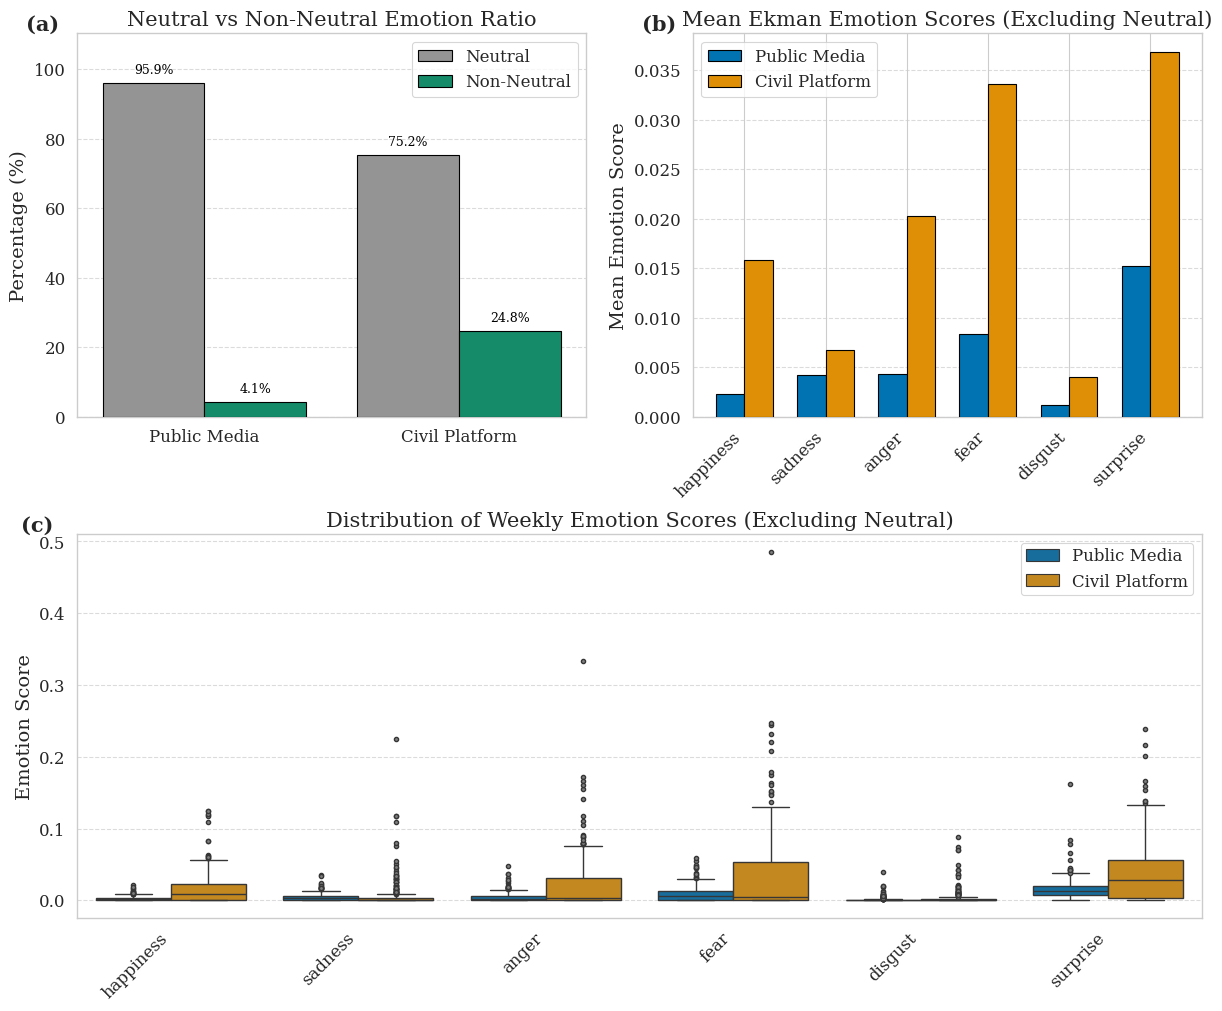

In [12]:
# --- 전처리: neutral 제외 감정 리스트 ---
emotions_no_neutral = [emo for emo in emotion_groups_ekman.keys() if emo != 'neutral']

# --- 테마 & 폰트 설정 ---
sns.set_theme(style="whitegrid", context="paper", palette="colorblind")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.titlesize'] = 15 # 타이틀 폰트 크기 약간 조정
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# palette 설정
platform_palette = {
    'Public Media': sns.color_palette("colorblind")[0],
    'Civil Platform': sns.color_palette("colorblind")[1]
}
emotion_type_palette = {
    'Neutral': sns.color_palette("colorblind")[7],
    'Non-Neutral': sns.color_palette("colorblind")[2]
}

# --- Figure & GridSpec ---
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# --- (a) Neutral vs Non-Neutral Ratio ---
total_public = weekly_public.sum(axis=0, numeric_only=True)
total_civil  = weekly_civil.sum(axis=0, numeric_only=True)

def ratio_dict(s):
    neu = s.get('neutral', 0)
    non = s.drop('neutral', errors='ignore').sum()
    tot = neu + non
    return {'Neutral': neu/tot*100, 'Non-Neutral': non/tot*100} if tot>0 else {'Neutral':0,'Non-Neutral':0}

ratios = (
    pd.DataFrame({
        'Public Media': ratio_dict(total_public),
        'Civil Platform': ratio_dict(total_civil)
    })
    .T
    .reset_index()
    .rename(columns={'index':'Platform'})
    .melt(id_vars='Platform', var_name='Emotion Type', value_name='Ratio')
)

sns.barplot(
    data=ratios, x='Platform', y='Ratio', hue='Emotion Type',
    palette=emotion_type_palette, ax=ax1, edgecolor='black', zorder=3
)

max_ratio = ratios['Ratio'].max()
ax1.set_ylim(0, max_ratio * 1.15)

for p in ax1.patches:
    val = p.get_height()
    if val > 1e-3:
        ax1.text(
            p.get_x() + p.get_width()/2,
            val + max_ratio * 0.02,
            f'{val:.1f}%',
            ha='center', va='bottom',
            fontsize=9, color='black'
        )

ax1.set_ylabel('Percentage (%)')
ax1.set_xlabel('')
# ✨ 변경된 부분 1: 제목에서 '(a)' 제거
ax1.set_title('Neutral vs Non-Neutral Emotion Ratio')
ax1.legend(title='', loc='upper right', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
# ✨ 변경된 부분 2: 좌측 상단에 텍스트로 '(a)' 추가
ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')


# --- (b) Mean Emotion Scores ---
avg_pub = stats_public.loc['mean', emotions_no_neutral]
avg_civ = stats_civil.loc['mean', emotions_no_neutral]
x = np.arange(len(emotions_no_neutral))
w = 0.35

ax2.bar(x-w/2, avg_pub, w, label='Public Media',
        color=platform_palette['Public Media'], edgecolor='black', zorder=3)
ax2.bar(x+w/2, avg_civ, w, label='Civil Platform',
        color=platform_palette['Civil Platform'], edgecolor='black', zorder=3)

ax2.set_xticks(x)
ax2.set_xticklabels(emotions_no_neutral, rotation=45, ha='right')
ax2.set_ylabel('Mean Emotion Score')
ax2.set_xlabel('')
# ✨ 변경된 부분 1: 제목에서 '(b)' 제거
ax2.set_title('Mean Ekman Emotion Scores (Excluding Neutral)')
ax2.legend(fontsize=12, loc='upper left')
ax2.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
# ✨ 변경된 부분 2: 좌측 상단에 텍스트로 '(b)' 추가
ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')


# --- (c) Weekly Distribution ---
pub = weekly_public.copy(); pub['Platform']='Public Media'
civ = weekly_civil.copy();  civ['Platform']='Civil Platform'
df_all = pd.concat([pub, civ]).melt(
    id_vars='Platform', value_vars=emotions_no_neutral,
    var_name='Emotion', value_name='Score'
)

sns.boxplot(
    data=df_all, x='Emotion', y='Score', hue='Platform',
    palette=platform_palette, flierprops=dict(marker='o', markersize=3, markerfacecolor='gray'),
    ax=ax3, zorder=3
)
ax3.set_xticks(np.arange(len(emotions_no_neutral)))
ax3.set_xticklabels(emotions_no_neutral, rotation=45, ha='right')

ax3.set_ylabel('Emotion Score')
ax3.set_xlabel('')
# ✨ 변경된 부분 1: 제목에서 '(c)' 제거
ax3.set_title('Distribution of Weekly Emotion Scores (Excluding Neutral)')
ax3.legend(
    title='',
    loc='upper right',
    fontsize=12,
    frameon=True,
    borderpad=0.3,
    labelspacing=0.5
)
ax3.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
# ✨ 변경된 부분 2: 좌측 상단에 텍스트로 '(c)' 추가
ax3.text(-0.05, 1.05, '(c)', transform=ax3.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')


# --- 최종 레이아웃 & 저장 ---
plt.savefig('Figure2.svg', dpi=300, bbox_inches='tight')
plt.savefig('Figure2.png', dpi=300, bbox_inches='tight')
plt.show()